# Task 3 — Aircraft Type Classification (Military vs Civilian) with Hugging Face VLMs


## 1. Установка зависимостей и импорты библиотек

In [ ]:
%pip -q install -U openai scikit-learn pillow matplotlib tqdm python-dotenv pandas


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import csv
import os, pathlib, json, random, base64, time
from dataclasses import dataclass
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
import pandas as pd
from typing import Dict, Optional, List
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

## 2. Конфигурация


In [ ]:
# === Путь к данным ===
DATA_DIR = "./planes"        # <-- Папка с фото самолётов
LABELS_CSV = f"{DATA_DIR}/labels.csv"       # например: "./planes/labels.csv" или оставьте None
RESULTS_DIR = "./results"    # куда сохраняем артефакты
LIMIT = 30                   # не больше 30, чтобы не уткнуться в лимиты

# === Выбор моделей ===
MODELS = [
    "Qwen/Qwen3-VL-8B-Instruct",
    "zai-org/GLM-4.5V"
]
# По желанию: провайдеры (строки) для каждой модели, или None чтобы выбрать автоматически
PROVIDERS = ["novita", "zai-org"]   # важное: привязать к провайдеру

# === Токен Hugging Face (Inference Providers) ===
# Можно объявить заранее:  export HF_TOKEN="hf_xxx"
# или хранить в .env (ключ=HF_TOKEN)
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")
if not HF_TOKEN:
    raise RuntimeError("Не найден HF_TOKEN. Создайте токен на hf.co/settings/tokens с правом 'Inference Providers'.")
    
os.makedirs(RESULTS_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)
print("LABELS_CSV:", LABELS_CSV)
print("RESULTS_DIR:", RESULTS_DIR)
print("MODELS:", MODELS)
print("PROVIDERS:", PROVIDERS)

DATA_DIR: ./planes
LABELS_CSV: ./planes/labels.csv
RESULTS_DIR: ./results
MODELS: ['Qwen/Qwen3-VL-8B-Instruct', 'zai-org/GLM-4.5V']
PROVIDERS: ['novita', 'zai-org']


## 3. Загрузка данных и разметки


In [135]:
LABELS = ("civilian", "military")

def collect_images(data_dir: str) -> List[str]:
    exts = {".jpg", ".jpeg", ".png", ".webp"}
    files = []
    for p in pathlib.Path(data_dir).glob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            files.append(str(p))
    return sorted(files)

def read_labels_csv(csv_path: str) -> Dict[str, str]:
    df = pd.read_csv(csv_path)
    labels = {}
    base = pathlib.Path(csv_path).parent
    for _, row in df.iterrows():
        fn = str(base / str(row["filename"]))
        labels[fn] = str(row["label"]).strip().lower()
    return labels

def normalize_label(text: str) -> Optional[str]:
    t = str(text).strip().lower()
    if "military" in t:
        return "military"
    if "civil" in t:
        return "civilian"
    if t in {"military", "civilian"}:
        return t
    return None

def infer_labels_from_filenames(files: List[str]) -> Dict[str, str]:
    labels = {}
    for p in files:
        name = pathlib.Path(p).name.lower()
        if any(k in name for k in ["military"]):
            labels[p] = "military"
        elif any(k in name for k in ["civil"]):
            labels[p] = "civilian"
    return labels

# Собираем файлы и метки
files = collect_images(DATA_DIR)
if not files:
    raise RuntimeError("В папке с данными не найдено изображений (.jpg/.jpeg/.png/.webp).")

if LABELS_CSV:
    labels_dict = read_labels_csv(LABELS_CSV)
else:
    labels_dict = infer_labels_from_filenames(files)

# Оставляем только размеченные
gt = {}
for f in files:
    if f in labels_dict:
        lab = normalize_label(labels_dict[f])
        if lab in LABELS:
            gt[f] = lab

if not gt:
    raise RuntimeError("Не найдено размеченных изображений. Используйте labels.csv или именование файлов.")

print(f"Всего изображений: {len(files)} | Размеченных: {len(gt)}")

# Вспомогательная таблица
df = pd.DataFrame([{"filename": pathlib.Path(k).name, "label": v} for k, v in gt.items()])
df.head()

Всего изображений: 30 | Размеченных: 30


,filename,label
0,1.jpeg,civilian
1,10.jpeg,civilian
2,11.png,military
3,12.png,civilian
4,13.png,military


### 3.1. Быстрая визуальная проверка (несколько примеров)

/home/vasaby/Documents/Georgiy/Институт/МАГА/ИСИТ/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


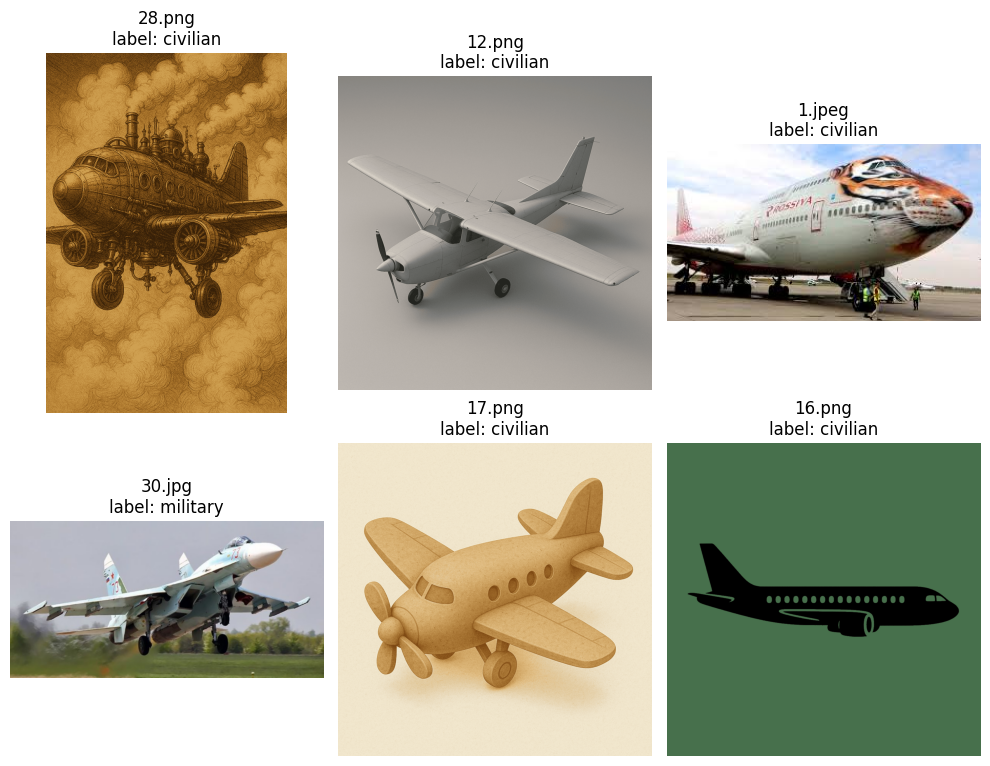

In [136]:
sample = list(gt.items())
random.seed(42)
sample = random.sample(sample, k=min(6, len(sample)))

fig = plt.figure(figsize=(10, 8))
for i, (p, lab) in enumerate(sample, 1):
    try:
        img = Image.open(p).convert("RGB")
        ax = plt.subplot(2, 3, i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{pathlib.Path(p).name}\nlabel: {lab}")
    except Exception as e:
        print("Ошибка отображения", p, e)
plt.tight_layout(); plt.show()

## 4. Классификатор на базе Hugging Face Inference Providers (OpenAI-совместимый API)


In [ ]:
def encode_image_to_data_url(path: str) -> str:
    ext = pathlib.Path(path).suffix.lower().lstrip(".")
    if ext not in {"jpg", "jpeg", "png", "webp"}:
        ext = "jpeg"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:image/{ext};base64,{b64}"

@dataclass
class VLMConfig:
    name: str
    provider: Optional[str] = None  # например: "together", "sambanova", ...

class HfVlmClassifier:
    def __init__(self, api_key: str, model_id: str, provider: Optional[str] = None, temperature: float = 0.0):
        self.client = OpenAI(base_url="https://router.huggingface.co/v1", api_key=api_key)
        self.base_model = model_id              # <- сохраняем базовый id
        self.provider = provider                # <- сохраняем провайдера (вот этой строки не хватало)
        self.model = f"{model_id}:{provider}" if provider else model_id
        self.temperature = temperature
        self.response_format = {
            "type": "json_schema",
            "json_schema": {
                "name": "plane_type",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "label": {"type": "string", "enum": ["civilian", "military"]},
                        "confidence": {"type": "number", "minimum": 0, "maximum": 1},
                        "rationale": {"type": "string"}
                    },
                    "required": ["label", "confidence"]
                }
            }
        }

    def classify(self, image_path: str, retry: int = 2) -> Dict:
        img_data = encode_image_to_data_url(image_path)
        prompt = (
            "Classify the airplane in this photo strictly as 'civilian' or 'military'. "
            "Consider cues like livery, windows, weapon pylons, refueling booms, serial numbers, etc. "
            "Output JSON with fields: label, confidence (0..1), rationale (short)."
        )
        last_err = None
        for _ in range(retry + 1):
            try:
                completion = self.client.chat.completions.create(
                model=f"{self.model}:{self.provider}" if self.provider else self.model,
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},  # твой текст-инструкцию
                        {"type": "image_url", "image_url": {"url": img_data}},  # data:image/jpeg;base64,...
                    ],
                }],
                response_format={"type": "json_object"},
                max_tokens=200,
                temperature=0,
                )
                data = json.loads(completion.choices[0].message.content)  # дальше как у тебя

                msg = completion.choices[0].message
                data = json.loads(msg.content) if isinstance(msg.content, str) else msg.content
                lab = normalize_label(data.get("label", ""))
                if not lab:
                    raise ValueError(f"Bad label in response: {data}")
                data["label"] = lab
                data["raw"] = msg.content
                return data
            except Exception as e:
                last_err = e
                time.sleep(1.2)
        raise RuntimeError(f"Inference failed for {image_path}: {last_err}")

print("Классификатор готов.")

Классификатор готов.


## 5. Метрики и визуализации

In [138]:
def evaluate(y_true: List[str], y_pred: List[str]):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label="military", zero_division=0
    )
    return acc, p, r, f1

def plot_confusion(y_true, y_pred, title, out_png=None):
    cm = confusion_matrix(y_true, y_pred, labels=list(LABELS))
    fig = plt.figure(figsize=(4,4))
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_xticks(range(len(LABELS))); ax.set_yticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS); ax.set_yticklabels(LABELS)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    fig.colorbar(im)
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160)
    plt.show()

## 6. Запуск инференса по модели (с кэшем)

In [139]:
def run_eval_for_model(model: VLMConfig, gt: Dict[str, str], limit: int, out_dir: str, token: str):
    os.makedirs(out_dir, exist_ok=True)
    cache_path = os.path.join(out_dir, f"cache_{model.name.replace('/','_').replace(':','-')}.json")
    cache = {}
    if os.path.exists(cache_path):
        cache = json.load(open(cache_path, "r", encoding="utf-8"))

    items = list(gt.items())
    if limit and len(items) > limit:
        random.seed(42)
        items = random.sample(items, k=limit)

    clf = HfVlmClassifier(api_key=token, model_id=model.name, provider=model.provider)
    y_true, y_pred = [], []
    per_item = {}

    for img_path, true_lbl in tqdm(items, desc=f"Infer {model.name}"):
        if img_path in cache:
            pred = cache[img_path]
        else:
            pred = clf.classify(img_path)
            cache[img_path] = pred
            json.dump(cache, open(cache_path, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
        y_true.append(true_lbl)
        y_pred.append(pred.get("label", ""))
        per_item[img_path] = {
            "true": true_lbl,
            "pred": pred.get("label", ""),
            "confidence": pred.get("confidence", None),
            "rationale": pred.get("rationale", ""),
        }

    acc, p, r, f1 = evaluate(y_true, y_pred)

    # Сохраняем csv с предсказаниями
    pred_csv = os.path.join(out_dir, f"pred_{model.name.replace('/','_').replace(':','-')}.csv")
    with open(pred_csv, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filename", "true", "pred", "confidence", "rationale"])
        for k, v in per_item.items():
            w.writerow([pathlib.Path(k).name, v["true"], v["pred"], v["confidence"], (v["rationale"] or "").replace(',', ' ')])

    # Матрица ошибок
    cm_png = os.path.join(out_dir, f"cm_{model.name.replace('/','_').replace(':','-')}.png")
    plot_confusion(y_true, y_pred, f"{model.name}", out_png=cm_png)

    # Текстовый отчёт
    report_txt = os.path.join(out_dir, f"report_{model.name.replace('/','_').replace(':','-')}.txt")
    with open(report_txt, "w", encoding="utf-8") as f:
        f.write(classification_report(y_true, y_pred, labels=list(LABELS)))
        f.write("\\n")
        f.write(json.dumps({
            "model": model.name,
            "n": len(y_true),
            "accuracy": float(acc),
            "precision_military": float(p),
            "recall_military": float(r),
            "f1_military": float(f1),
        }, ensure_ascii=False, indent=2))

    return {"model": model.name, "n": len(y_true), "accuracy": acc, "precision": p, "recall": r, "f1": f1}, per_item

## 7. Запуск двух моделей и сравнение

In [140]:
client = OpenAI(base_url="https://router.huggingface.co/v1", api_key=HF_TOKEN)
for m in ["Qwen/Qwen3-VL-8B-Instruct:novita", "zai-org/GLM-4.5V:zai-org"]:
    r = client.chat.completions.create(
        model=m,
        messages=[{"role": "user", "content": [{"type":"text","text":"Say ok."}]}],
        max_tokens=5,
    )
    print(m, "->", r.choices[0].message.content)


Qwen/Qwen3-VL-8B-Instruct:novita -> OK.
zai-org/GLM-4.5V:zai-org -> 


Infer Qwen/Qwen3-VL-8B-Instruct: 100%|██████████| 30/30 [00:00<00:00, 332881.27it/s]


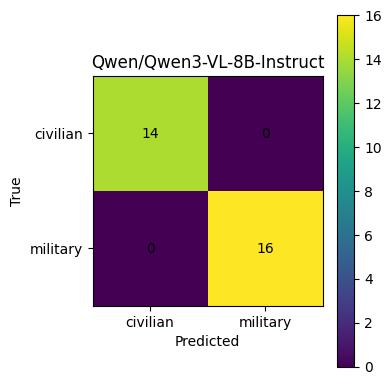

Infer zai-org/GLM-4.5V: 100%|██████████| 30/30 [00:00<00:00, 316153.57it/s]


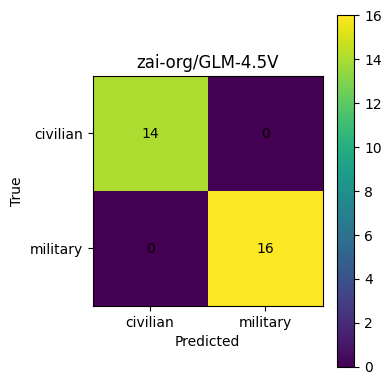

\n=== SUMMARY ===
Qwen/Qwen3-VL-8B-Instruct: n=30 acc=1.000 F1(military)=1.000  P=1.000 R=1.000
zai-org/GLM-4.5V: n=30 acc=1.000 F1(military)=1.000  P=1.000 R=1.000


,model,n,accuracy,precision,recall,f1
0,Qwen/Qwen3-VL-8B-Instruct,30,1.0,1.0,1.0,1.0
1,zai-org/GLM-4.5V,30,1.0,1.0,1.0,1.0


In [141]:
summary = []
all_preds = {}

for i, m in enumerate(MODELS):
    prov = PROVIDERS[i] if i < len(PROVIDERS) else None
    res, per_item = run_eval_for_model(VLMConfig(m, prov), gt, LIMIT, RESULTS_DIR, HF_TOKEN)
    summary.append(res)
    all_preds[m] = per_item

print("\\n=== SUMMARY ===")
for s in summary:
    print(f"{s['model']}: n={s['n']} acc={s['accuracy']:.3f} F1(military)={s['f1']:.3f}  P={s['precision']:.3f} R={s['recall']:.3f}")

df_summary = pd.DataFrame(summary)
df_summary